Load Packages

For this task, we use Google Colab. This is because Colab has already integrated with many packages. Also, the Colab is running on virtual machine, so model training will not slow down  local PC.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

Read data from Google Drive

The data is shared in our common project folder 

https://drive.google.com/file/d/1_Fm_fLc-d8UO6rBG5_ibGbFLdlDaRum5/view?usp=sharing

Please refer to the following steps to first mount Google Drive on colab

https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

In [ ]:
# read data from google drive
US_factor = pd.read_csv('/content/drive/MyDrive/INDENG 242 project/US_Factor.csv')

Define panel data generator

this function converts US_factor into a dictionary, where each key corresponds to  a date

In [ ]:
def gen_panel_data(data,date_column,drop_columns):
    out = dict()
    date_column = ''.join(date_column)
    date_ls = data[date_column].drop_duplicates()
    for k, t in enumerate(date_ls):
        data_slice = data[data[date_column]==t].copy()
        data_slice.loc[:, 'R1M_Usd_binary'] = (data_slice['R1M_Usd'] >= np.median(data_slice['R1M_Usd']))*1
        data_slice = data_slice.drop(drop_columns, axis=1)
        data_slice = data_slice.set_index('stock_id')
        out[t] = data_slice
    return out

In [ ]:
cs_data = gen_panel_data(data=US_factor,date_column=['date'],
    drop_columns=['date','R3M_Usd','R6M_Usd','R12M_Usd','R1M_Usd_C','R12M_Usd_C'])

# Walk-forward model training function

This function uses walk-forward method to create a series of test set performances over time. We use this series of test set performance to pick the predicted outperformers on each month: 

-  For regression, we pick the predicted outperformers by selecting stocks whose predicted returns are above median, and calculate the mean of their true returns

- For classification, we pick the predicted outperformers who are predicted = 1, and calculate the mean of their true returns



About the function:

*walk_forward_optim* 

input: 
-  the training configuration
-  the data dictionary, e.g. "cs_data"

output: 
- a dictionary containing predictions and optimized hyperparameters

In [ ]:
def walk_forward_optim(model_config, data_dict, verbose=True):
    output = dict()
    output['hyperparam'] = []
    output['prediction'] = dict()
    output['objective'] = model_config['objective']
    timeline = [i for i in data_dict.keys()]
    output['start_date'] = timeline[0]
    
    model_params = dict()
    if model_config['objective'] == 'classification':
        y_lab = 'R1M_Usd_binary'
    elif model_config['objective'] == 'regression':
        y_lab = 'R1M_Usd'
    else:
        raise ValueError()

    #train_len = model_config['train_len']
    train_len = 1
    model_instance = model_config['model_instance']
    train_freq = model_config['train_freq']
    cv_freq = model_config['cv_freq']
    param_grid = model_config['param_grid']
    train_cnt = 0
    cv_cnt = 0

    # handle parameter input exceptions
    for k,t in enumerate(timeline[train_len:]):
        X_test = data_dict[t].drop(['R1M_Usd','R1M_Usd_binary'], axis=1)
        Y_true = data_dict[t][['R1M_Usd']].copy()
        if k % train_freq==0:
            # then re-train model
            # prepare modelling data
            train_label = timeline[k:(k + train_len)]
            data_train = pd.concat([data_dict[i] for i in train_label], axis=0)
            X_train = data_train.drop(['R1M_Usd','R1M_Usd_binary'], axis=1)
            X_train = X_train.dropna(axis=0)
            Y_train = data_train[y_lab]

            try:
                if_cv = (train_cnt % cv_freq == 0)
            except:
                if_cv = False
            if if_cv:
                model_obj = model_instance()
                model_cv = GridSearchCV(model_obj,
                                        param_grid=param_grid,
                                        cv=model_config['cv_fold'],
                                        scoring=model_config['scoring'],
                                        n_jobs=-1)

                model_cv.fit(X_train, Y_train)

                model_params = model_cv.best_params_
                output['hyperparam'].append(model_params)

                if verbose:
                    print(t,'predicted,',str(cv_cnt+1)+'th','CV used,',str(train_cnt+1)+'th','model trained')
                # fit gridsearch cv
                # collect the best parameter
                cv_cnt = cv_cnt+1
            else:
                if verbose:
                    print(t, 'predicted,', 'No new CV used,', str(train_cnt+1) + 'th', 'model trained')
            # fit X_train and Y_train with old parameters
                model_cv = model_instance(**model_params)
                model_cv.fit(X_train, Y_train)
            train_cnt = train_cnt + 1

        else:
            # predict Y_test from X_test
            if verbose:
                print(t, 'predicted, No new CV used, no new model trained')

        Y_pred = model_cv.predict(X_test)

        Y_true.loc[:,'Y_pred'] = Y_pred
        output['prediction'][t] = Y_true

    return output

## Example 1: Gradient Boosting Regressor

### Step 1: specify training configurations

First, we need to specify the training configuration. The training configuration is also a dictionary, with each key indicating a training setting for the walk-forward optimization.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor # import the ML class from sklearn.

# create an empty dictionary to fill in configuration settings
regressor_config = dict() 

# set the model class
regressor_config['model_instance'] = GradientBoostingRegressor 

# specify choice of hyperparameters
# - this is similar to the parameter grid that we supplt to gridsearch CV
# - here I wouldl ike to optimize two parameters: leanring rate and n_estimators
regressor_config['param_grid'] = {'learning_rate': [0.01,0.1],'n_estimators':[100, 200]}

# specify the task:
# use either 'regression' or 'classification'
regressor_config['objective'] = 'regression' 

# specify CV scoring:
# here I use negative mean squared error as the regression task scoring
# check here for alternative scorings: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
regressor_config['scoring'] = 'neg_mean_squared_error' #  

# specify how frequent we wish to train the model
# here, 3 means I train a model (e.g. build a new model) once every three months
# the higher the training frequency, the longer the function to runs
regressor_config['train_freq'] = 3

# specify how frequent we wish to optimize hyperparameters
# here, 3 means I optimize hyperparameters once every three training sessions, or once every (3*3=9) nine months
# the higher the CV frequency, the longer the function to runs
regressor_config['cv_freq'] = 3 #

# indicating the fold number of K-fold CV:
# 3 means we use 3-fold CV
# bigger number increases runtime a lot! so be careful!
regressor_config['cv_fold'] = 3

# the number of CPUs to run the function
regressor_config['n_jobs'] = -1 

### Step 2: run the walk-forward optimization to obtain model predictions on each test set

After we specify the parameters, we run the function on data:

In [ ]:
keys = [i for i in cs_data.keys()]
cs_data_demo =cs_data_test = {key: cs_data[key] for key in keys[135:]}

In [ ]:
# Set verbose = True will make the function print out messages, so we can keep track of trainining schedule
regressor_result = walk_forward_optim(model_config=regressor_config,data_dict=cs_data, verbose=True) 

The runtime could take as long as 10 min to 30min, depending on how fine we wish to tune the hyperparameters. With our specified training configurations, the function takes  9 minutes to complete

### Step 3: have a look on the training results

After tuning is completed, we can access the results

*walk_forward_optim* outputs a dictionary as its result. 

The dictionary contains two main items
-   the 'prediction' key contains a nested dictionary, which in turn contains model predictions and true return for each month. 

- the 'hyperparameter' key contains a list, which in turn contains the optimal hyperparameters obtained from each CV. This gives us an idea whether the optimal hyperparameters are stable overtime.

In [ ]:
# this calls the prediction result on 2020-04-30, which is a dataframe object
regressor_result['prediction']['2000-04-30']

,R1M_Usd,Y_pred
stock_id,,
1,0.448,-0.026924
2,-0.114,0.465295
3,0.027,-0.035084
4,-0.011,-0.057360
5,-0.031,0.435141
...,...,...
1208,0.070,-0.217743
1209,-0.103,-0.194034
1210,0.073,-0.028427


We can also access the historical optimal hyperparameters obtained from each training. Note that the historical optimal hyperparameters are stored in a list.

In [ ]:
regressor_result['hyperparam']

[{'learning_rate': 0.1, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 200},
 {'learning_rate': 0.01, 'n_estimators': 200},
 {'learning_rate': 0.01, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 200},
 {'learning_rate': 0.01, 'n_estimators': 200},
 {'learning_rate': 0.01, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 200},
 {'learning_rate': 0.01, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 200},
 {'learning_rate': 0.01, 'n_estimators': 200},
 {'learning_rate': 0.01, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 200},
 {'learning_rate': 0.01, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 100},
 {'learning_rate': 0.01, 'n_estimators': 200},
 {'learning_ra

It seems that the learning rate has been quite stable over time, as 0.01 is always the best one. However, the number of estimators fluctuate up and down a bit

# Step 4: converting model prediction to stock returns

On this step, we pick the predicted outperformers and calculate their mean returns on each month.

The mean return on each month are then converted to cumulative returns or portfolio net values. This like creating a hypothetical portfolio that shows how much money we can make if we are to invest according to our model predictions!

The cumulative turns allows us to compare different models (regressors vs classifiers) on a unified scale.

We also compares the cumulative returns from our model with market average returns, to see if we can "beat" the market on long run (which is very challenging!)

To do this, we take the outout from *walk_forward_optim* and use it as input for *gen_portfolio_return*.

*gen_portfolio_return* generates cumulative predicted returns from the model and cumulative average returns of the market, which is used as a benchmark for model comparison.

In [ ]:
def gen_portfolio_return(results, keep_top=0.5):
    porfolio_ls = []
    market_ls = []
    pred_dict = results['prediction']
    task = results['objective']
    start = results['start_date']
    timeline = [i for i in pred_dict.keys()]

    for k,i in enumerate(timeline):
        arr = pred_dict[i].values

        arr_sorted = arr[np.argsort((-1*arr[:, 1]))][:,0]
        if task == 'regression':
            cutoff = round(len(arr) * keep_top)
            metric = np.mean(arr_sorted[:cutoff])
        else:
            cutoff = (arr[:, 1] >= 0.5)
            metric = np.mean(arr[:, 0][cutoff])
        porfolio_ls.append(metric)
        market_ls.append(np.mean(arr[:, 0]))
    porfolio_ls = [1]+porfolio_ls
    market_ls = [1]+market_ls

    out = pd.DataFrame({'portfolio_ret':np.cumsum(porfolio_ls),
                        'market_ret':np.cumsum(market_ls)},
                       index=[start]+timeline)
    return out

We can generate the results as follows: 

In [ ]:
regressor_ret = gen_portfolio_return(regressor_result)
regressor_ret

,portfolio_ret,market_ret
2000-01-31,1.000000,1.000000
2000-02-29,1.033205,1.064126
2000-03-31,1.023753,1.077656
2000-04-30,0.997014,1.070463
2000-05-31,0.982611,1.087883
...,...,...
2018-08-31,3.877779,3.958289
2018-09-30,3.797516,3.875290
2018-10-31,3.825878,3.899742
2018-11-30,3.721753,3.792812


Then visualize it with plot:

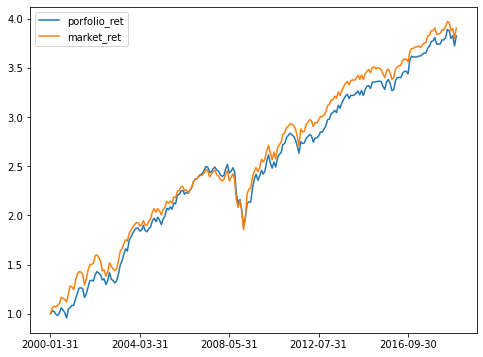

In [ ]:
regressor_ret.plot(figsize=(8,6))
# the blue line indicates the hypothetical portfolio returns from our model
# the orange line indicates the market return, which resembles a stock index

Ohhhh, it seems like we did not beat the market consistently! This is understable, since we use a very simple configuration: only 3-fold CV, tuned only 2 parameters for 2*2 = 4 grid values. 

# Example 2: Gradient Boost Classifier

In this example, I remove all the comments & instructions to demonstrate the full pipeline of one analysis.

It is a fairly simple procedure.

Simply setting the training configurations, then letting the model run for a while, then collecting the outcome and generating the cumulative returns. 

To find the best results, we try around different training configurations, as follows:

- what is the best frequency of model training? Does mroe frequent training lead to better predictions?

- what hyperparameters should we optimize? what grid values should we use?

- Do the optimal hyperparameters remain stable over time?

- What is the best scoring metric for regression and for classification? 

**The analysis pipeline:**

In [ ]:
# model configurations:
from sklearn.ensemble import GradientBoostingClassifier
classifier_config = dict()
classifier_config['model_instance'] = GradientBoostingClassifier
classifier_config['param_grid'] ={'max_depth': [3, 8],'subsample':[0.3, 0.7]}
classifier_config['objective'] = 'classification'  # remember this is a classification task
classifier_config['scoring'] = 'roc_auc' # I use average_precision
classifier_config['train_freq'] = 3 # train model once every three months
classifier_config['cv_fold'] = 3 # 3-fold cross-validation
classifier_config['cv_freq'] = 3 # grid-search CV once every three trainings, or, once every nine months
classifier_config['n_jobs'] = -1 

In [ ]:
# run walk_forward_optim function:
classifier_result = walk_forward_optim(model_config=classifier_config,data_dict=cs_data, verbose=True)

This specific configuration takes about 8 minutes to complete.

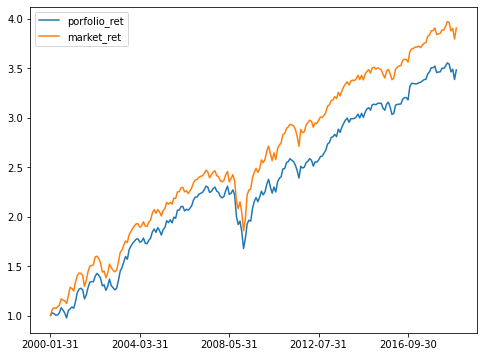

In [ ]:
# generate cumulative returns, and visualize the resuls
classifier_ret = gen_portfolio_return(classifier_result)
classifier_ret.plot(figsize=(8, 6))

That's it! The analysis pipeline is done!

We can also compare the cumulatives returns generated from the regressor versus the classifier

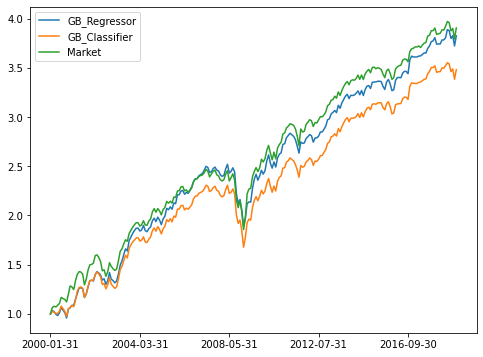

In [ ]:
compare = pd.concat([regressor_ret['portfolio_ret'],classifier_ret],axis=1)
compare.columns = ['GB_Regressor','GB_Classifier','Market']
compare.plot(figsize=(8,6))

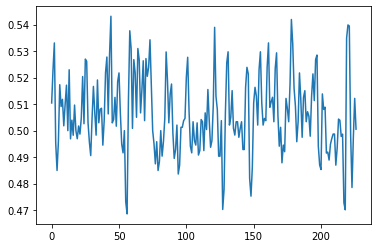

In [ ]:
class_balance = []
keys = [i for i in classifier_result['prediction'].keys()]
for i in keys:
  class_balance.append(classifier_result['prediction'][i]['Y_pred'].eq(1).sum()/len(classifier_result['prediction'][i]))
plt.plot(class_balance)
plt.show()

# Other empirical results

We use google colab to carry out model training invidually, so please note that the following codes are the combined version of each individual's selected results as full training iterations are way too lengthy to be included (each training prints 200 records)

Linear regressions

In [ ]:
from sklearn.linear_model import Lasso
linearmodel_config = dict()
linearmodel_config['model_instance'] = Lasso
linearmodel_config['param_grid'] = {'alpha': np.linspace(0, 0.01, 50)}
linearmodel_config['objective'] = 'regression'
linearmodel_config['scoring'] = 'neg_root_mean_squared_error'
linearmodel_config['train_freq'] = 1
linearmodel_config['cv_fold'] = 6
linearmodel_config['cv_freq'] = 1
linearmodel_config['n_jobs'] = -1

In [ ]:
keys = [i for i in cs_data.keys()]
cs_data_demo =cs_data_test = {key: cs_data[key] for key in keys[135:]}
regressor_result = walk_forward_optim(model_config=linearmodel_config,data_dict=cs_data, verbose=True) 

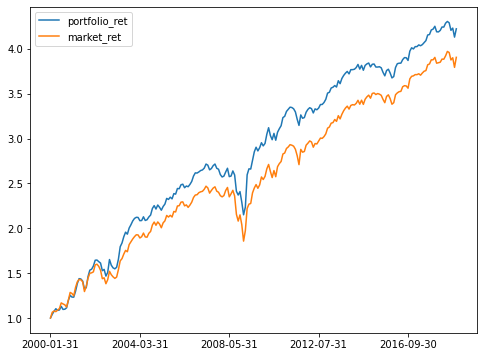

In [ ]:
regressor_ret = gen_portfolio_return(regressor_result)
regressor_ret.plot(figsize=(8,6))

In [ ]:
optimal_hyperparameter = pd.DataFrame(regressor_result['hyperparam'])
optimal_hyperparameter['alpha']

In [ ]:
optimal_hyperparameter.to_csv('hyperparam3.csv')

In [ ]:
regressor_ret.to_csv('optimal_cumulative_return.csv')

CART Classifier

In [ ]:
# model configurations:
classifier_config = dict()
classifier_config['model_instance'] = DecisionTreeClassifier
classifier_config['param_grid'] ={'ccp_alpha': np.linspace(0, 0.1, 500)}
classifier_config['objective'] = 'classification'  # remember this is a classification task
classifier_config['scoring'] = 'roc_auc' # I use average_precision
classifier_config['train_freq'] = 1 # train model once every three months
classifier_config['cv_fold'] = 5 # 3-fold cross-validation
classifier_config['cv_freq'] = 3 # grid-search CV once every three trainings, or, once every nine months
classifier_config['n_jobs'] = -1 

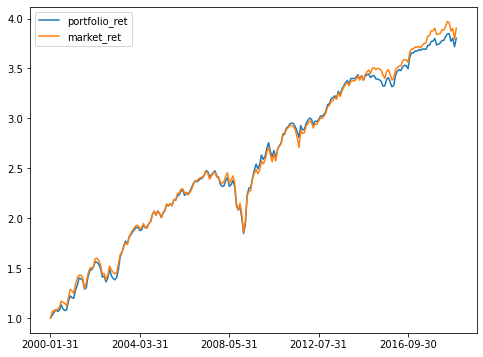

In [ ]:
# generate cumulative returns, and visualize the resuls
classifier_ret_1 = gen_portfolio_return(classifier_result_1)
classifier_ret_1.plot(figsize=(8, 6))

In [ ]:
# model configurations:
classifier_config_2 = dict()
classifier_config_2['model_instance'] = DecisionTreeClassifier
classifier_config_2['param_grid'] ={'ccp_alpha': np.linspace(0, 0.1, 100),'min_samples_leaf':(3,10,1)}
classifier_config_2['objective'] = 'classification'  # remember this is a classification task
classifier_config_2['scoring'] = 'accuracy' # I use average_precision
classifier_config_2['train_freq'] = 2 # train model once every three months
classifier_config_2['cv_fold'] = 5 # 3-fold cross-validation
classifier_config_2['cv_freq'] = 3 # grid-search CV once every three trainings, or, once every nine months
classifier_config_2['n_jobs'] = -1 

In [ ]:
classifier_result_2 = walk_forward_optim(model_config=classifier_config_2,data_dict=cs_data, verbose=True)

In [ ]:
# model configurations:
classifier_config_3 = dict()
classifier_config_3['model_instance'] = DecisionTreeClassifier
classifier_config_3['param_grid'] ={'ccp_alpha': np.linspace(0, 0.1, 100),'max_features':(50,80,30)}
classifier_config_3['objective'] = 'classification'  # remember this is a classification task
classifier_config_3['scoring'] = 'roc_auc' # I use average_precision
classifier_config_3['train_freq'] = 2 # train model once every three months
classifier_config_3['cv_fold'] = 5 # 3-fold cross-validation
classifier_config_3['cv_freq'] = 3 # grid-search CV once every three trainings, or, once every nine months
classifier_config_3['n_jobs'] = -1 

In [ ]:
classifier_result_3 = walk_forward_optim(model_config=classifier_config_3,data_dict=cs_data, verbose=True)

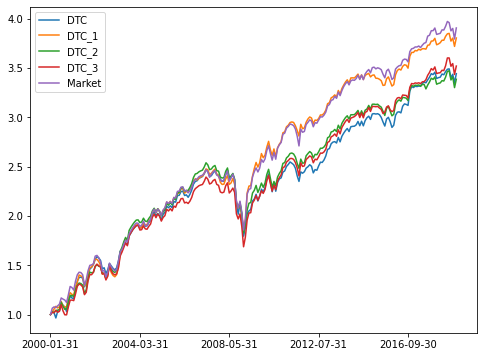

In [ ]:
compare = pd.concat([classifier_ret['portfolio_ret'],classifier_ret_1['portfolio_ret'],classifier_ret_2['portfolio_ret'],classifier_ret_3['portfolio_ret'],classifier_ret['market_ret']],axis=1)
compare.columns = ['DTC','DTC_1','DTC_2','DTC_3','Market']
compare.plot(figsize=(8,6))

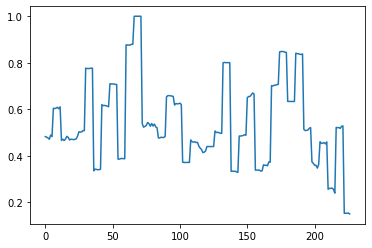

In [ ]:
class_balance = []
keys = [i for i in classifier_result['prediction'].keys()]
for i in keys:
  class_balance.append(classifier_result['prediction'][i]['Y_pred'].eq(1).sum()/len(classifier_result['prediction'][i]))
plt.plot(class_balance)
plt.show()

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor # import the ML class from sklearn.
rfregressor_config5 = dict() 
rfregressor_config5['model_instance'] = RandomForestRegressor 
rfregressor_config5['param_grid'] = {'n_estimators':[25, 50],'max_features':['auto', 'sqrt'],'max_depth':[3, 10]} 
rfregressor_config5['objective'] = 'regression' 
rfregressor_config5['scoring'] = 'neg_mean_squared_error' #  
rfregressor_config5['train_freq'] = 1
rfregressor_config5['cv_freq'] = 6 #
rfregressor_config5['cv_fold'] = 5
rfregressor_config5['n_jobs'] = -1

In [ ]:
# run walk_forward_optim function:
rf_result = walk_forward_optim(model_config=rfregressor_config5,data_dict=cs_data, verbose=True)

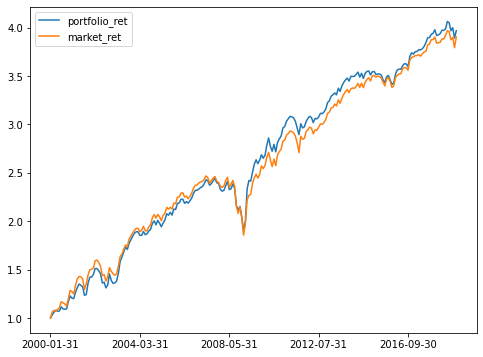

In [ ]:
rf_ret8 = gen_portfolio_return(rf_result)
rf_ret8.plot(figsize=(8,6))

In [ ]:
rf_ret = gen_portfolio_return(rf_result,net_val=True)
rf_ret.diff().mean()/rf_ret.diff().std()

portfolio_ret    0.254626
market_ret       0.244448
dtype: float64

In [ ]:
rf_param = pd.DataFrame(rf_result['hyperparam'])
rf_param.head()

,max_depth,max_features,n_estimators
0,10,sqrt,50
1,10,auto,25
2,10,sqrt,50
3,10,sqrt,50
4,10,auto,50


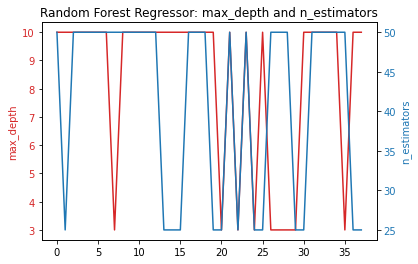

In [ ]:

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('max_depth', color=color)
ax1.plot(rf_param['max_depth'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('n_estimators', color=color)  # we already handled the x-label with ax1
ax2.plot(rf_param['n_estimators'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Random Forest Regressor: max_depth and n_estimators')
plt.show()

Gradient Boosting 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor # import the ML class from sklearn.
regressor_config4 = dict() 
regressor_config4['model_instance'] = GradientBoostingRegressor 
regressor_config4['param_grid'] = {'learning_rate': [0.001, 0.1],'n_estimators':[25, 100],'max_features':['auto', 'sqrt'],'min_samples_leaf':[1, 5]} 
regressor_config4['objective'] = 'regression' 
regressor_config4['scoring'] = 'neg_mean_squared_error' #  
regressor_config4['train_freq'] = 2
regressor_config4['cv_freq'] = 6 #
regressor_config4['cv_fold'] = 5
regressor_config4['n_jobs'] = -1 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor # import the ML class from sklearn.
regressor_config5 = dict() 
regressor_config5['model_instance'] = GradientBoostingRegressor 
regressor_config5['param_grid'] = {'learning_rate': [0.001, 0.1],'n_estimators':[25, 100],'max_features':['auto', 'sqrt'],'min_samples_leaf':[1, 5]} 
regressor_config5['objective'] = 'regression' 
regressor_config5['scoring'] = 'neg_mean_squared_error' #  
regressor_config5['train_freq'] = 1
regressor_config5['cv_freq'] = 12 #
regressor_config5['cv_fold'] = 5
regressor_config5['n_jobs'] = -1 

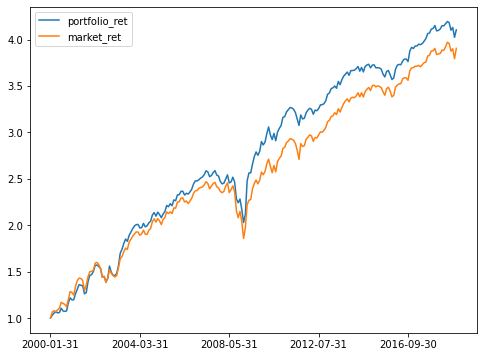

In [ ]:
regressor_ret5 = gen_portfolio_return(regressor_result5)
regressor_ret5.plot(figsize=(8,6))

In [ ]:
gb_param = pd.DataFrame(regressor_result5['hyperparam'])
gb_param.head()

,learning_rate,max_features,min_samples_leaf,n_estimators
0,0.1,sqrt,5,100
1,0.1,sqrt,1,25
2,0.1,auto,1,25
3,0.1,auto,1,25
4,0.1,sqrt,5,25


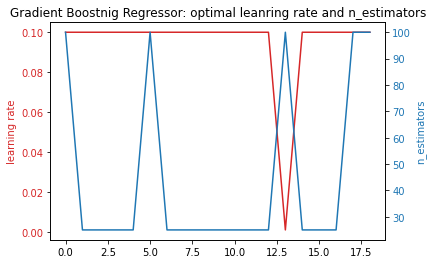

In [ ]:

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('learning rate', color=color)
ax1.plot(gb_param['learning_rate'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('n_estimators', color=color)  # we already handled the x-label with ax1
ax2.plot(gb_param['n_estimators'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Gradient Boostnig Regressor: optimal leanring rate and n_estimators')
plt.show()